**Notebook reference:**

[kubeflow-kale/examples/pytorch-classification/cifar10_classification.ipynb](https://github.com/kubeflow-kale/examples/blob/master/pytorch-classification/cifar10_classification.ipynb) with some manually modification to use the GPU.

**Other references:**


* Install properly torch version according to cuda driver version

https://github.com/pytorch/pytorch/issues/4546

* Check if torch is using the gpu

https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu

https://discuss.pytorch.org/t/solved-make-sure-that-pytorch-using-gpu-to-compute/4870

* Monitor:

```
watch -n 3 nvidia-smi --query-gpu=index,gpu_name,memory.total,memory.used,memory.free,temperature.gpu,pstate,utilization.gpu,utilization.memory --format=csv
```

* Cifar10 example:

http://www.cs.toronto.edu/~kriz/cifar.html

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://discuss.pytorch.org/t/how-to-convert-layer-list-in-nn-module-to-cpu-or-gpu/36223/2

* Cifar10 kale example:

https://github.com/kubeflow-kale/examples/blob/master/pytorch-classification/cifar10_classification.ipynb

* Blog regarding cifar10 example

https://tomroth.com.au/pytorch-cnn/

## Pytorch pipeline

Pytroch pipeline to train and validate on the CIFAR10 dataset

The produced pipeline is composed of the following steps:

**1. data-processing**: Download and preprocess CIFAR10 dataset (**this already is done**)

**2. visualization**: Visualize and show statistics about the dataset  
**3. train**: Train the deep learning model  
**4. test-on-test**: Test the model on the test set  
**5. test-on-whole**: Test the model performance on the whole dataset  

The pipeline is sequential, so every step in dependent on the previous one.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
TRAIN_STEPS = 2

#### Load and transform dataset

Download:

`aws s3 cp s3://data-for-kale-tests/cifar10/cifar-10-batches-py /shared_volume/data/torch/cifar10/data/cifar-10-batches-py/ --recursive`

In [4]:
#input_data_folder = "./data"
input_data_folder = "/shared_volume/data/torch/cifar10/data/"
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=input_data_folder, train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=input_data_folder, train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

#### Visualize dataset

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

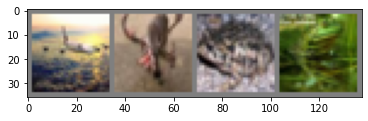

plane  deer  frog  frog


In [6]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Define model

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Define loss func and optimizer

In [8]:
import torch.optim as optim
device = torch.device("cuda:0")
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### Train

In [9]:
device = torch.device("cuda:0")
for epoch in range(TRAIN_STEPS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.233
[1,  4000] loss: 1.844
[1,  6000] loss: 1.636
[1,  8000] loss: 1.558
[1, 10000] loss: 1.494
[1, 12000] loss: 1.430
[2,  2000] loss: 1.356
[2,  4000] loss: 1.323
[2,  6000] loss: 1.322
[2,  8000] loss: 1.245
[2, 10000] loss: 1.262
[2, 12000] loss: 1.249
Finished Training


#### Test on test data

In [10]:
device = torch.device("cuda:0")
dataiter = iter(testloader)
n = dataiter.next()
images, labels = n[0].to(device), n[1].to(device)

# print images
#imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

GroundTruth:    cat  ship  ship plane


In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


#### Performance on whole dataset

In [13]:
device = torch.device("cuda:0")
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [14]:
device = torch.device("cuda:0")
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 76 %
Accuracy of  bird : 37 %
Accuracy of   cat : 29 %
Accuracy of  deer : 54 %
Accuracy of   dog : 50 %
Accuracy of  frog : 64 %
Accuracy of horse : 70 %
Accuracy of  ship : 70 %
Accuracy of truck : 60 %
